<a href="https://colab.research.google.com/github/nandinikalita/MACHINE-LEARNING/blob/master/ARIMA_timeForecasting_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load the CSV file into a DataFrame
pd.set_option('display.max_rows', None)
csv_path = "/content/gdrive/MyDrive/Colab_Notebooks/future-gc00-daily-prices.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)

# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [4]:
print(data.dtypes)

Open     object
High     object
Low      object
Close    object
dtype: object


we would have to handle indexing issues, which is important in time series forecasting. For example, since we are forecasting the closing value of a stock on a particular exchange, we have to consider that the stock market is not open on weekends.

In [5]:
#Data preprocessing
# Clean the "Close" column
data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)

<ipython-input-5-df11a2df9780>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)


Handle missing values

As part of data preprocessing, we also often have to consider how to handle missing values using an imputation method like forward filling or mean replacement. Do know that even one NA value, depending on the programming language and the library you are using, can prevent an ARIMA from running.

I had mentioned that weekend days might be recognized as NA. That's can be the case, and would require an extra step. Luckily, statsmodels treats the data as a sequential index without strictly enforcing regular time intervals, allowing our model to compile even weekend gaps.

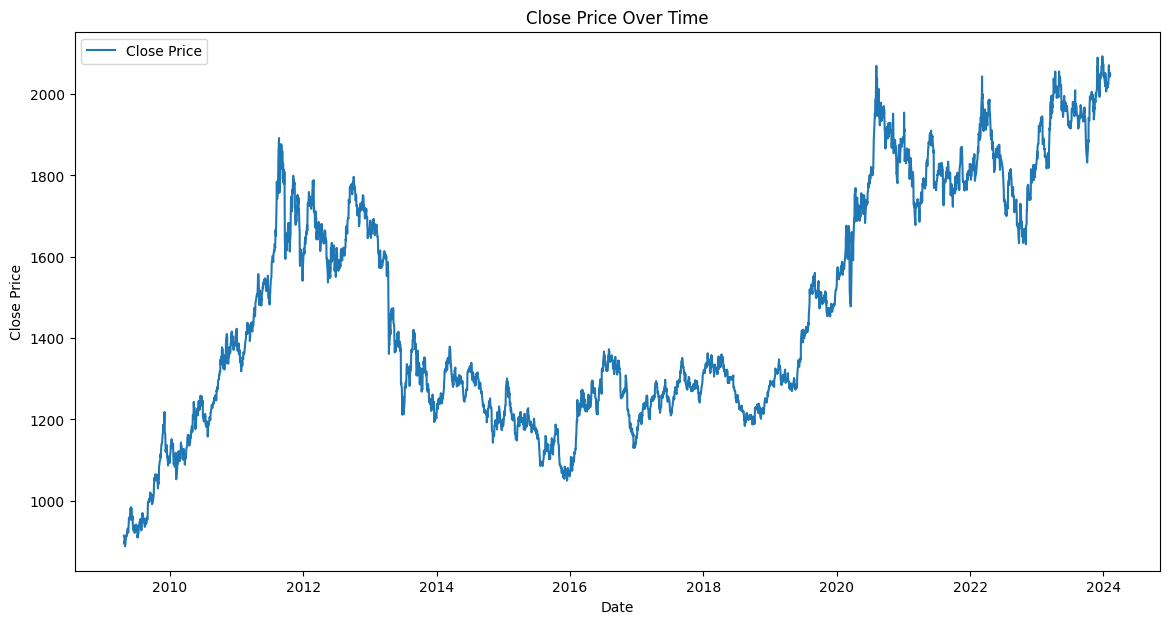

In [6]:
# Create a time plot
# Plotting the original Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Close"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Check for stationarity and perform differencing if necessary:

While ARIMA models can deal with non-stationarity up to a point, they cannot effectively account for time-varying variance. In other words, for an ARIMA model to really work, the data has to be stationary.

Looking at the plot, above, we can see that the data is, in fact, not stationary because there is a clear trend. Also, it looks like there is non-constant variance at different time points. We can use the Augmented Dickey-Fuller test to test our intuition and see if our data has a constant mean and variance, and put numbers to it.

<Axes: xlabel='year', ylabel='Close'>

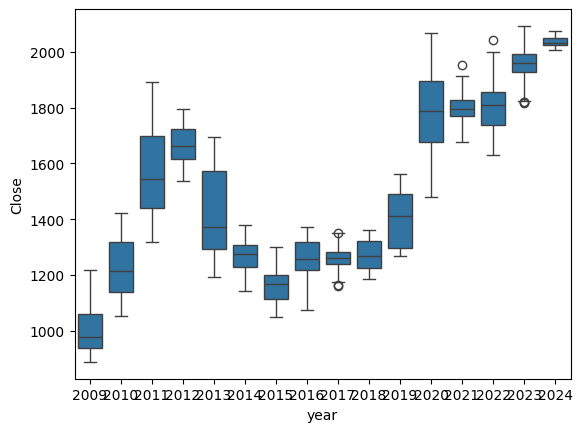

In [7]:
#
data['year'] = [d.year for d in data.index]
data['month'] = [d.strftime('%b') for d in data.index]
years = data['year'].unique()

#Plot yearly and monthly values as boxplot
sns.boxplot(x='year', y='Close', data=data)


<Axes: xlabel='month', ylabel='Close'>

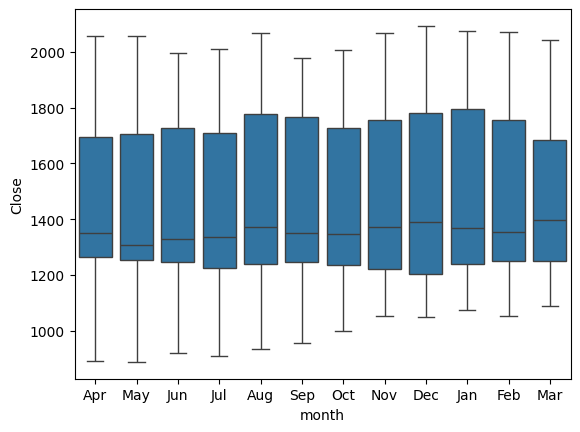

In [8]:
sns.boxplot(x='month', y='Close', data=data)


In [9]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(data["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -1.4367
p-value (Original): 0.5646
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -19.1308
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


The results of our Augmented Dickey-Fuller test indicate that our original series is, in fact, non-stationary, so using an ARIMA out-of-the-box on the original data would be a mistake.

The ADF test on a differenced version of the data indicates that the differenced version is stationary, however.

A quick note on differencing. I want to take the time to explain this, since a lot is happening under the hood. To perform differencing, we subtract each observation from the previous one to give us a new time series of first differences. (The new time series is now one element shorter than the original.) If the differenced series is still not stationary, we can take a second difference by differencing the original series again, and we can continue differencing the series until it finally becomes stationary. The order of differencing required is the minimum number of differences needed to get a series with no autocorrelation.

I do want to say, finally - don't perform differencing more than you have to, otherwise you might create some false dynamics in your data. Also, if you were going to do seasonal ARIMA model, which we aren't doing in this tutorial, you would always consider a seasonal difference before a first difference.

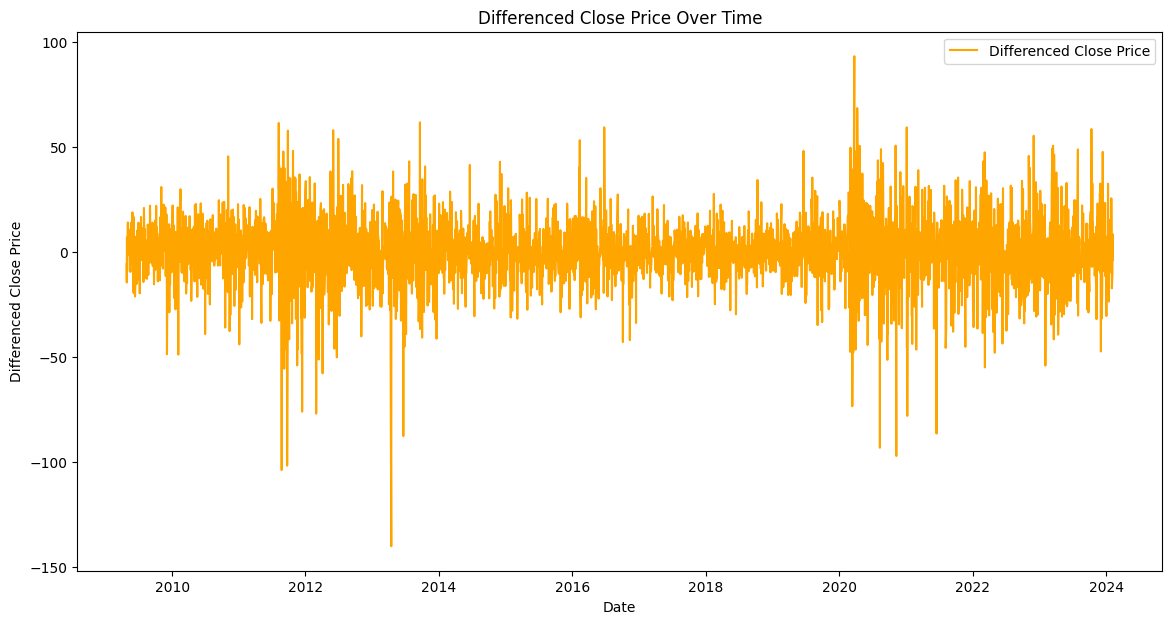

In [10]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

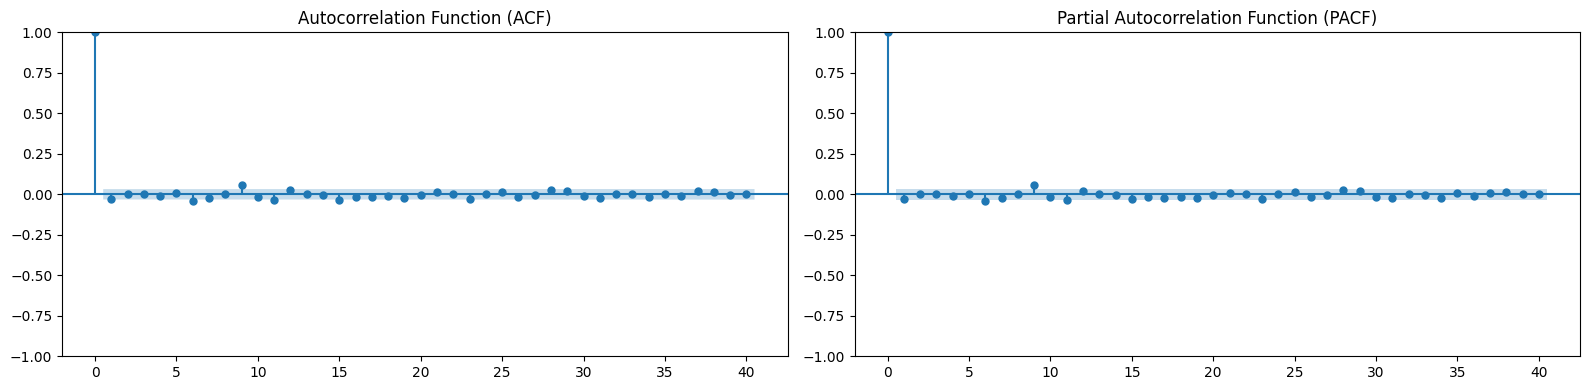

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [12]:
#Extract and plot trend, seasonal and residuals.
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data['Close'], period=1000, model ='additive')

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

In [14]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

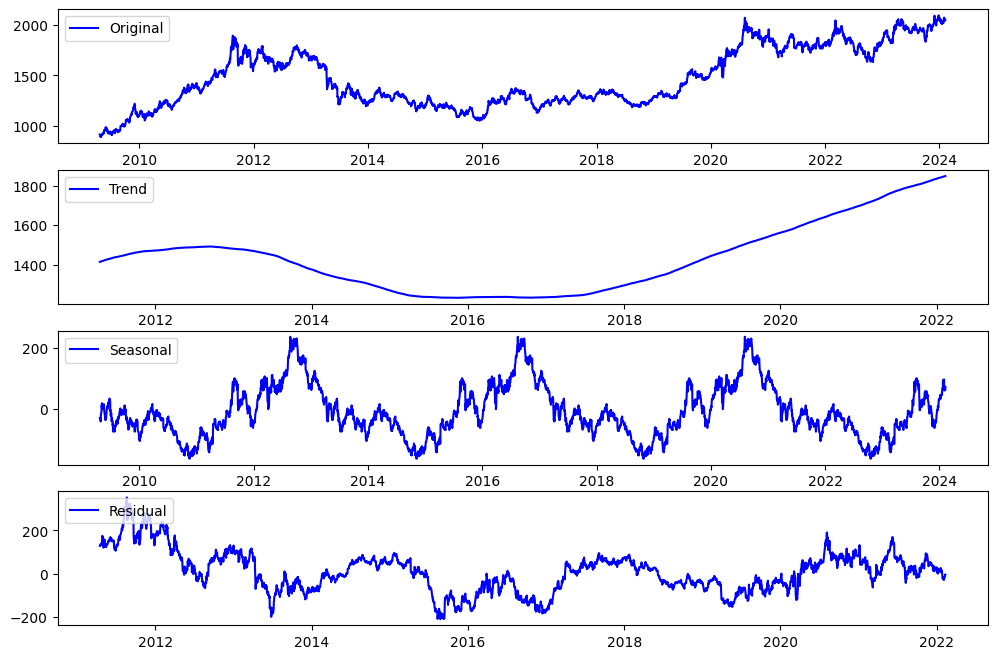

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(data['Close'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='blue')
plt.legend(loc='upper left')
plt.show()

#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

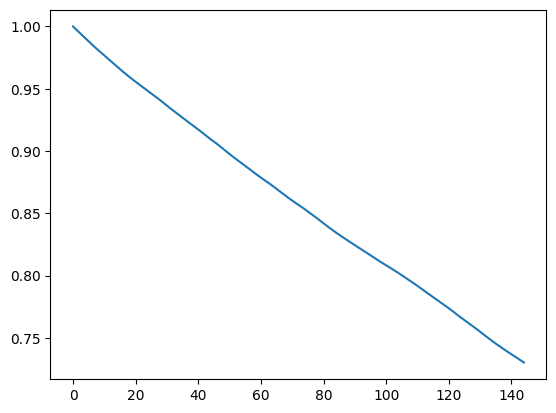

In [16]:
from statsmodels.tsa.stattools import acf

acf_144 = acf(data.Close, nlags=144)
plt.plot(acf_144)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

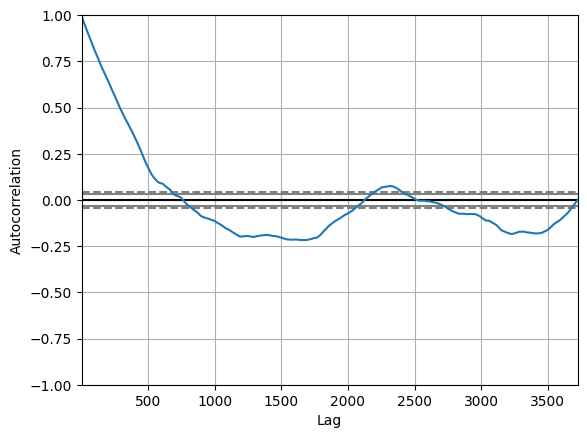

In [17]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data.Close)
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#A strong positive correlation for lags below 700 (months)

Model identification :

When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model.

The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags.
The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary.
The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

Finding the ARIMA terms :

We use tools like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to determine the values of p, d, and q. The number of lags where ACF cuts off is q, and where PACF cuts off is p. We also have to choose the appropriate value for d by creating a situation where, after differencing, the data resembles white noise. For our data, we choose 1 for both p and q because we see a significant spike in the first lag for each.


Parameter estimation :

To be clear, the p, d, and q values in ARIMA represent the model's order (lags for autoregression, differencing, and moving average terms), but they are not the actual parameters being estimated. Once the p, d, and q values are chosen, the model estimates additional parameters, such as coefficients for the autoregressive and moving average terms, through maximum likelihood estimation (MLE).

Forecasting :

To forecast using an ARIMA model, start by using the fitted model to predict future values based on the data. Once predictions are made, it's helpful to visualize them by plotting the predicted values alongside the actual values. This is accomplished because we use a train/test workflow, where the data is split into training and testing sets. Doing this lets us see how well the model performs on unseen data. If you are unclear on this, take our Model Validation in Python course, which is a great resource to learn the ins and outs of training and testing.

1. Use a train/test workflow

As data is time series, so we take first 80% percent dataset using len in train and rest in test. We cant randomlyt select 80% as the data is sequential

In [18]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2. Visualize our time series

Our next step is to create our forecast and also to visually inspect it. We can see how our forecast performs against the testing version of our data.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


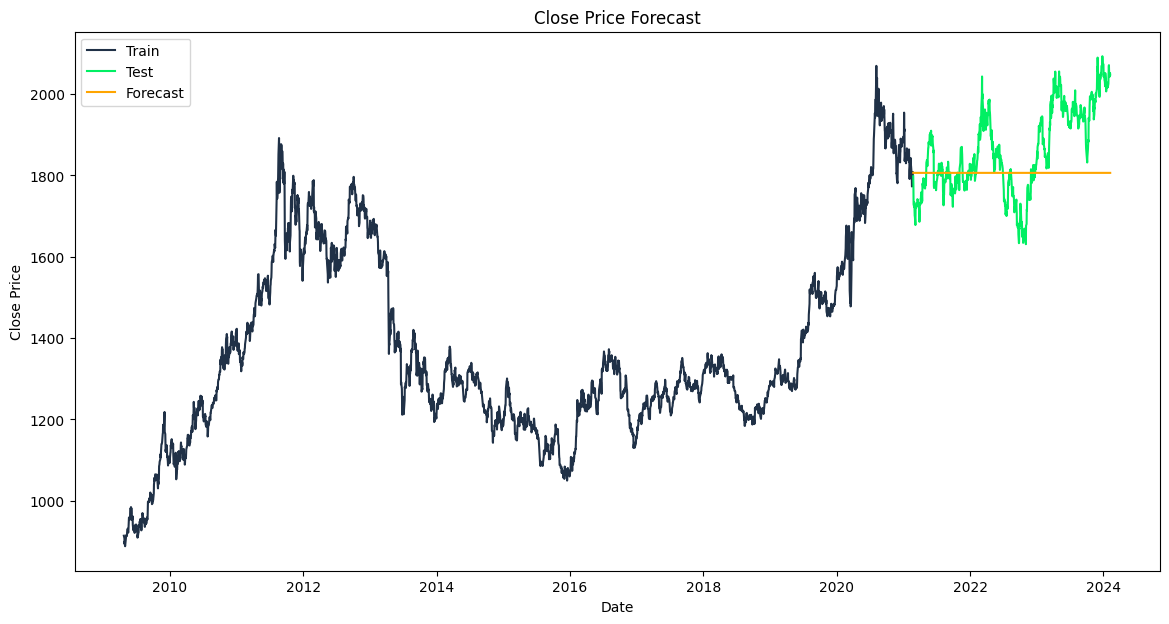

In [19]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

3. Evaluate model statistics

We check out the AIC and BIC model statistics. Lower values mean the model fits better, but we might also compare the results with those from simpler models to avoid overfitting. I'm printing the numbers here but they make the most sense in the context of comparing to other ARIMA models on the same data, in order to find the ARIMA model that works best.

In [20]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24602.974260667514
BIC: 24620.971282307244


We can also evaluate the mean squared error, to assess our model's fit. This is a practical metric. A lower RMSE indicates a better ARIMA model, reflecting smaller differences between actual and predicted values, and it's on the scale of the data. That is, the RMSE of 118.5339 signifies that, on average, our model's predictions deviate from the actual Close prices by about $118.53.

In [21]:
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 118.5339
